In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from swarmrl.tasks.MPI_chain import ChainTask
file_path = "trajectory.hdf5"
time_step = 0
import bottleneck as bn
with h5py.File(file_path, 'r') as file:
    time_step = file['rafts']['Times'][1] - file['rafts']['Times'][0]

2025-02-26 09:22:32.564630: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.20. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


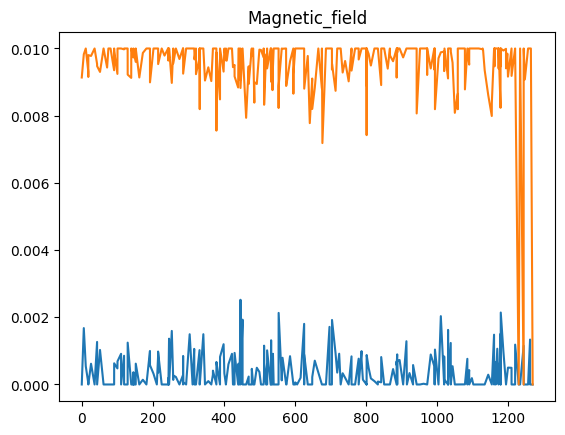

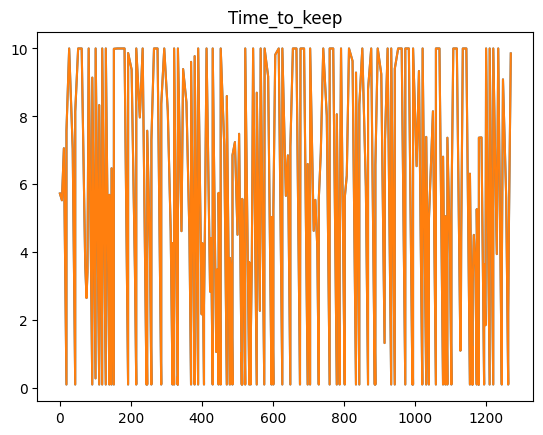

<Figure size 640x480 with 0 Axes>

In [2]:
def calculate_rotating_magnetic_field(amplitude, frequency, offset, phase, time):
    return amplitude * np.sin(2 * np.pi * frequency * time + phase) + offset

# Open the HDF5 file

def sine_B_field(calculate_rotating_magnetic_field, time, actions):
    action_chunk = {
        "Amplitudes": actions["Amplitudes"][:],
        "Frequencies": actions["Frequencies"][:],
        "Offsets": actions["Offsets"][:],
        "Phases": actions["Phases"][:],
    }
    
    for key, values in action_chunk.items():
        plt.figure()
        plt.plot(values[:])
        plt.title(key)
        
    plt.figure()
    magnetic_field = calculate_rotating_magnetic_field(
        action_chunk["Amplitudes"],
        action_chunk["Frequencies"],
        action_chunk["Offsets"],
        action_chunk["Phases"],
        time)
        
    plt.plot(time, magnetic_field)
    plt.title('Rotating Magnetic Field')
    plt.xlabel('Time')
    plt.ylabel('Magnetic Field')
    
    plt.figure()
    plt.plot(magnetic_field[-100:,0], magnetic_field[-100:,1])
    plt.title("b field ")

with h5py.File(file_path, 'r') as f:
    # List all groups
    time = f["rafts"]["Times"][:].flatten()
    time = np.array([time,time])
    time = np.transpose(time)
    actions = f["actions"]
    action_chunk = {
        "Magnetic_field": actions["Magnetic_field"][:],
        "Time_to_keep": actions["Time_to_keep"][:],
    }

    for key, values in action_chunk.items():
        plt.figure()
        plt.plot(time,values[:])
        plt.title(key)

    plt.figure()
    # dynamic_magnetic_field = []
    # passed_time = 0
    # for i in range(len(action_chunk["Magnetic_field"])):
    #     plt.scatter(passed_time, action_chunk["Magnetic_field"][i][0], c='r')
    #     plt.scatter(passed_time, action_chunk["Magnetic_field"][i][1], c='b')
    #     passed_time += action_chunk["Time_to_keep"][i]
    #     plt.axvline(x=passed_time, color='k', linestyle='--',alpha=0.5)
    #     plt.scatter(passed_time, action_chunk["Magnetic_field"][i][0], c="r")
    #     plt.scatter(passed_time, action_chunk["Magnetic_field"][i][1], c="b")

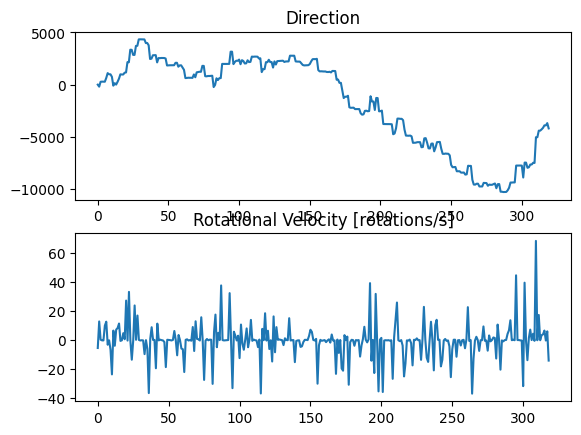

In [3]:
with h5py.File(file_path, 'r') as f:
    fig, ax = plt.subplots(2,1)
    direction = np.array(f["rafts"]["Alphas"])
    direction = np.mean(direction, axis=1)
    ax[0].plot(direction.flatten())
    ax[0].set_title("Direction")
    rot_vel = np.array([direction[i+1] - direction[i] for i in range(len(direction)-1)])/(time_step * 2 * np.pi)
    # ax[1].set_ylim(-100,100)
    ax[1].plot(np.squeeze(rot_vel))
    ax[1].set_title("Rotational Velocity [rotations/s]")
    

In [ ]:
from matplotlib.animation import FuncAnimation
with h5py.File(file_path, 'r') as f:
    pos = f["rafts"]["Unwrapped_Positions"][:]
fig, ax = plt.subplots()
ax.set_xlim(0, 10000)
ax.set_ylim(0, 10000)
scat = ax.scatter(pos[0, :, 0], pos[0, :, 1])

def update(frame):
    scat.set_offsets(pos[frame, :, :])
    return scat,

ani = FuncAnimation(fig, update, frames=range(len(pos)), blit=True)
ani.save('trajectory.mp4', writer='ffmpeg', fps=30)

now at -1.3653980281469118, improvement -0.045289176694423894, improvement last 10% 0.007437640432032211
best reward at 1127.934326171875, -0.9793542197549885
best regression error at 26.094730377197266, -0.3971045911312103
best angle error at 704.4816284179688, -0.41210261205725224


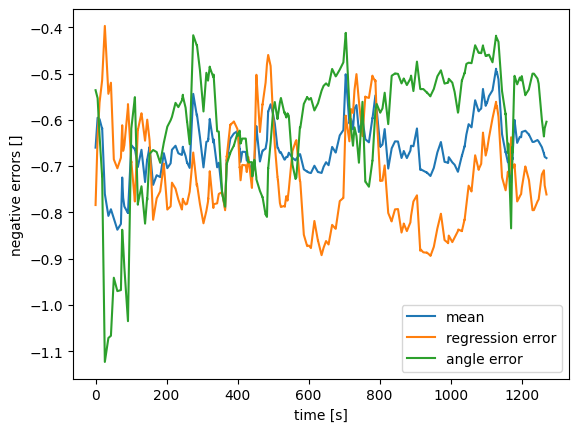

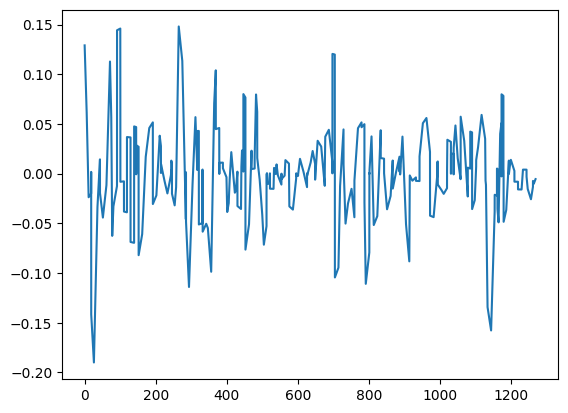

In [4]:
task = ChainTask()
regression_error= []
reward = []
angle_error = []
with h5py.File(file_path, 'r') as f:
    pos = np.array(f["rafts"]["Unwrapped_Positions"])
    time = np.array(f["rafts"]["Times"])
    time = time.flatten()
    angle_normalization, regression_normalization = 1.672994399605725, 2064.0876

    for i in range(len(pos)):
        _,_,regression_error_single = task.orthogonal_regression_svd(pos[i,:,0], pos[i,:,1])
        angle_error_single = task.angle_between_particles(pos[i,:,0], pos[i,:,1])
        regression_error.append(-regression_error_single/regression_normalization)
        angle_error.append(-angle_error_single/angle_normalization)
    reward = np.array(regression_error) + np.array(angle_error)
    plt.plot(time, (np.array(regression_error) + np.array(angle_error))/2, label="mean")
    plt.plot(time, regression_error, label="regression error")
    plt.plot(time, angle_error, label="angle error")
    plt.ylabel("negative errors []")
    plt.xlabel("time [s]")
    plt.legend()
    # plt.axhline(y=reward[0], color="r", linestyle="--")
    # plt.plot(time[np.argmax(reward)],np.max(reward), 'ro')
    # plt.ylim(-1.5, 0.3)
    print(f"now at {reward[-1]}, improvement {reward[-1] - reward[0]}, improvement last 10% {reward[-1] - reward[-len(reward)//10]}")
    print(f"best reward at {time[np.argmax(reward)]}, {np.max(reward)}")
    print(f"best regression error at {time[np.argmax(regression_error)]}, {np.max(regression_error)}")
    print(f"best angle error at {time[np.argmax(angle_error)]}, {np.max(angle_error)}")
    plt.show()
    plt.figure()
    reward = np.gradient(reward) 
    plt.plot(time, reward)